In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap

In [40]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Print the shape
print('Data set shape', df.shape)

Data set shape (1470, 35)


# 1. Preprocessing

In [41]:
# Handling missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurre

In [42]:
#dropping irrelevant and constant features
cols_to_drop = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber']
df.drop(columns=cols_to_drop, inplace=True)

# Outlier handling
# Using log transformation to reduce skewness
df['MonthlyIncomeLog'] = df['MonthlyIncome'].apply(lambda x: np.log1p(x))

# cap extream outliers for MonthlyIncome
income_99 = df['MonthlyIncome'].quantile(0.99)

# Encoding categorical variables
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['Gender']   = df['Gender'].map({'Male': 1, 'Female': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

# One hot encode multi class categories
df = pd.get_dummies(df, columns=['BusinessTravel','Department','EducationField','JobRole','MaritalStatus'], drop_first=True)

print("Shape after encoding:", df.shape)
# Separate features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

Shape after encoding: (1470, 46)


In [43]:
# Feature Scaling (standardise numercal features)
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
# remove created dummy colums and Attrition from numeric cols
numeric_cols = [col for col in numeric_cols if col not in ['Attrition'] and '_' not in col]
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Save preprocessed dataset for future use
processed_df = pd.concat([X, y], axis=1)
processed_df.to_csv('processed_attrition_data.csv', index=False)
print("Preprocessing done. Processed data saved to CSV.")

Preprocessing done. Processed data saved to CSV.


# 2. Feature Engineering

In [44]:
# Create a copy of preprocessed data set for feature engineering
df_fe = processed_df.copy()

# Interaction between jobRole and MonthlyIncome (via one-hot roles * income)
jobrole_cols = [col for col in df_fe.columns if col.startswith('JobRole_')]
for col in jobrole_cols:
    new_col = col + '_Income'
    df_fe[new_col] = df_fe[col] * df_fe['MonthlyIncome']

In [45]:
# Relative income to avarage. of the same JobRole
orig_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WA_Fn-UseC_-HR-Employee-Attrition.csv')
orig_df['Attrition'] = orig_df['Attrition'].map({'Yes':1,'No':0})
avg_income_by_role = orig_df.groupby('JobRole')['MonthlyIncome'].mean()

# Map each employee's JobRole to the average income of that role
df_fe['RoleAvgIncome'] = orig_df['JobRole'].map(avg_income_by_role)
# relative income = current income / avg income for that role
df_fe['RelIncomeToRoleAvg'] = df_fe['MonthlyIncome'] / df_fe['RoleAvgIncome']

# Tenure ratio (Years at company vs Age)
df_fe['TenureRatio'] = df_fe['YearsAtCompany'] / df_fe['Age']

# Promotion gap (if YearsAtCompany > 0)
df_fe['PromotionGap'] = df_fe.apply(lambda row: row['YearsSinceLastPromotion'] / row['YearsAtCompany']
                                    if row['YearsAtCompany'] > 0 else 0, axis=1)

print("Added engineered features. New shape:", df_fe.shape)

Added engineered features. New shape: (1470, 58)


# 3. Feature Selection

In [56]:
X_fe = df_fe.drop('Attrition', axis=1)
y_fe = df_fe['Attrition']

# Droping highly correlated features (treshold: 0.9)
corr_matrix = X_fe.corr().abs()
corr_matrix = X_fe.corr().abs()

# Use combinations to iterate through each pair of features only once
high_corr_pairs = []
for feature1, feature2 in itertools.combinations(corr_matrix.columns, 2):
    corr_value = corr_matrix.loc[feature1, feature2]
    if corr_value > 0.9:
        high_corr_pairs.append((feature1, feature2, corr_value))

# Print out the highly correlated feature pairs
if high_corr_pairs:
    print("Highly correlated feature pairs (corr > 0.9):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} and {pair[1]}: correlation = {pair[2]:.2f}")
else:
    print("No feature pairs with correlation > 0.9 found.")

Highly correlated feature pairs (corr > 0.9):
JobLevel and MonthlyIncome: correlation = 0.95
JobLevel and MonthlyIncomeLog: correlation = 0.92
MonthlyIncome and MonthlyIncomeLog: correlation = 0.94
MonthlyIncome and RoleAvgIncome: correlation = 0.90
MonthlyIncomeLog and RelIncomeToRoleAvg: correlation = 0.97
Department_Research & Development and Department_Sales: correlation = 0.91
JobRole_Laboratory Technician and JobRole_Laboratory Technician_Income: correlation = 0.93
JobRole_Manager and JobRole_Manager_Income: correlation = 0.98
JobRole_Research Director and JobRole_Research Director_Income: correlation = 0.96
JobRole_Research Scientist and JobRole_Research Scientist_Income: correlation = 0.93
JobRole_Sales Representative and JobRole_Sales Representative_Income: correlation = 0.98


In [57]:
# List of features to remove based on our correlation analysis:
features_to_remove = [
    'JobLevel',          # redundant with salary features
    'MonthlyIncome',     # we will use the log-transformed version instead
    'RoleAvgIncome',     # redundant with MonthlyIncomeLog
    'RelIncomeToRoleAvg' # redundant with MonthlyIncomeLog
]

# For department dummies, drop one
if 'Department_Sales' in X_fe.columns and 'Department_Research & Development' in X_fe.columns:
    features_to_remove.append('Department_Sales')

# For job role interaction terms: drop all columns that have the pattern '_Income' and start with 'JobRole_'
job_role_income_features = [col for col in X_fe.columns if col.startswith('JobRole_') and '_Income' in col]
features_to_remove.extend(job_role_income_features)

# Print the list of features to be removed
print("Features to be removed due to high correlation:", features_to_remove)

# Remove these features from X_fe
X_reduced = X_fe.drop(features_to_remove, axis=1)

print("Shape before removal:", X_fe.shape)
print("Shape after removal:", X_reduced.shape)

Features to be removed due to high correlation: ['JobLevel', 'MonthlyIncome', 'RoleAvgIncome', 'RelIncomeToRoleAvg', 'Department_Sales', 'JobRole_Human Resources_Income', 'JobRole_Laboratory Technician_Income', 'JobRole_Manager_Income', 'JobRole_Manufacturing Director_Income', 'JobRole_Research Director_Income', 'JobRole_Research Scientist_Income', 'JobRole_Sales Executive_Income', 'JobRole_Sales Representative_Income']
Shape before removal: (1470, 57)
Shape after removal: (1470, 44)


In [58]:
# REF using logistic regression
# Use a logistic regression (with no penalty or L2 to not bias feature selection) for RFE
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
rfe = RFE(logreg, n_features_to_select=10)  # choose top 10 features
rfe.fit(X_fe, y_fe)
selected_indices = rfe.get_support(indices=True)
selected_features = X_fe.columns[selected_indices]
print("Top 10 features selected by RFE:", list(selected_features))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Top 10 features selected by RFE: ['OverTime', 'MonthlyIncomeLog', 'BusinessTravel_Travel_Frequently', 'EducationField_Technical Degree', 'JobRole_Human Resources', 'JobRole_Sales Executive', 'MaritalStatus_Single', 'JobRole_Laboratory Technician_Income', 'JobRole_Sales Executive_Income', 'JobRole_Sales Representative_Income']


In [60]:
# Feature importance from Random Forest

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_fe, y_fe)
importances = pd.Series(rf.feature_importances_, index=X_fe.columns).sort_values(ascending=False)
print("Top 10 features by Random Forest importance:")
print(importances.head(10))

Top 10 features by Random Forest importance:
RelIncomeToRoleAvg    0.049865
MonthlyIncomeLog      0.047681
MonthlyIncome         0.044384
DailyRate             0.042945
Age                   0.042693
OverTime              0.042634
MonthlyRate           0.038774
TotalWorkingYears     0.037628
TenureRatio           0.037091
DistanceFromHome      0.036807
dtype: float64


# 4. Train-Test Split and Cross-Validation

In [63]:
# Assume df_fe is our final feature dataset after selection
X_final = X_fe.copy()
y_final = y_fe.copy()

# Train-test split (70/30 stratified)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.30, stratify=y_final, random_state=42)
print("Training set size:", X_train.shape[0], "Test set size:", X_test.shape[0])

# Cross-validation setup (5-fold Stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validate a logistic regression on training data for baseline
cv_scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, cv=cv, scoring='accuracy')
print("Logistic CV average accuracy: %.3f" % cv_scores.mean())

Training set size: 1029 Test set size: 441


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic CV average accuracy: 0.890


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
 # !pip install xgboost shap

In [66]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
# We can use GridSearchCV to tune inverse regularization strength C
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=cv, scoring='f1')
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
print("Best LogisticRegression params:", grid_lr.best_params_)

# Random Forest
rf_clf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 4]
}
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=cv, scoring='f1')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("Best RandomForest params:", grid_rf.best_params_)

# XGBoost
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.3]
}
grid_xgb = GridSearchCV(xgb_clf, param_grid_xgb, cv=cv, scoring='f1')
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("Best XGBoost params:", grid_xgb.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best LogisticRegression params: {'C': 1}
Best RandomForest params: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:12:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:12:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:12:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:12:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:12:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best XGBoost params: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}


In [67]:
# Train the best models on the full training set
best_lr.fit(X_train, y_train)
best_rf.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:12:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [68]:
models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

# Evaluate each model on test set
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # probability of class 1 (Attrition)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")

Logistic Regression - Accuracy: 0.884, Precision: 0.794, Recall: 0.380, F1: 0.514, AUC: 0.811
Random Forest - Accuracy: 0.832, Precision: 0.412, Recall: 0.099, F1: 0.159, AUC: 0.752
XGBoost - Accuracy: 0.848, Precision: 0.571, Recall: 0.225, F1: 0.323, AUC: 0.742


In [71]:
# Random Forest feature importance (already computed as 'importances' Series above)
print("Top features from Random Forest:", list(importances.head(8).index))

# XGBoost feature importance
xgb_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top features from XGBoost:", list(xgb_importances.head(8).index))

Top features from Random Forest: ['RelIncomeToRoleAvg', 'MonthlyIncomeLog', 'MonthlyIncome', 'DailyRate', 'Age', 'OverTime', 'MonthlyRate', 'TotalWorkingYears']
Top features from XGBoost: ['JobRole_Research Scientist', 'JobRole_Human Resources_Income', 'EducationField_Marketing', 'JobRole_Manufacturing Director', 'TotalWorkingYears', 'JobRole_Sales Executive_Income', 'JobRole_Manufacturing Director_Income', 'OverTime']


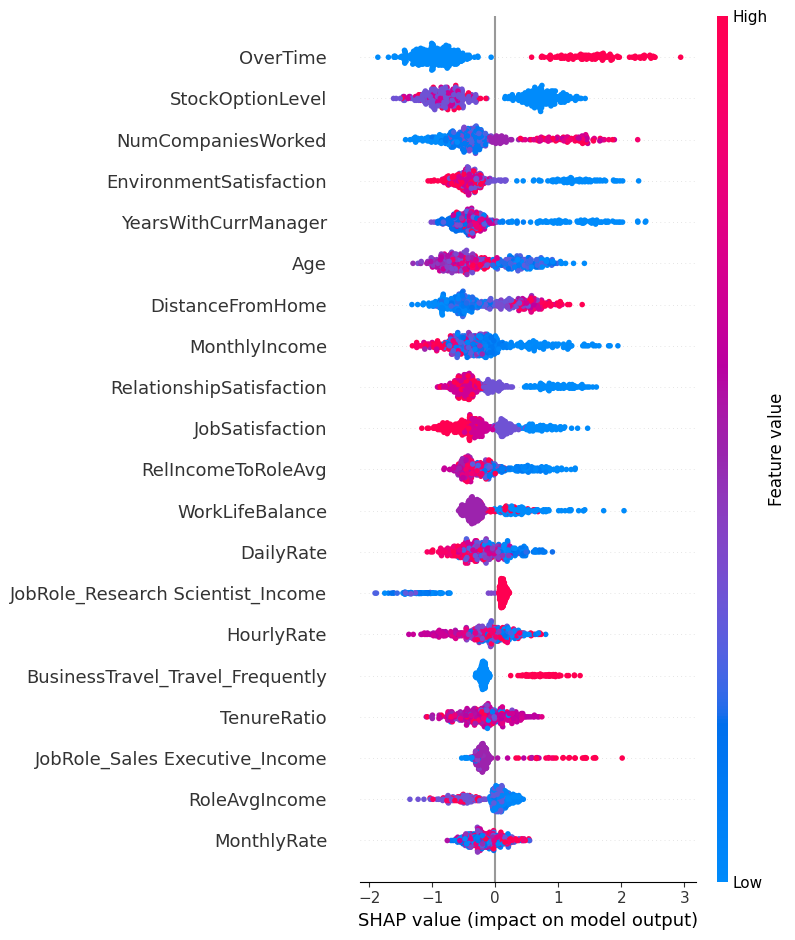

In [72]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot for global feature importance
shap.summary_plot(shap_values, X_test)

In [73]:
# SHAP force plot for a single example
sample = X_test.iloc[0]
shap.force_plot(explainer.expected_value, shap_values[0,:], sample)